In [1]:
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor
import matplotlib.pyplot as plt
import numpy as np

import sys
sys.path.append('../')
from ssbgm import ScoreBasedGenerator

In [2]:
np.random.seed(0)
N = 10000

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004026 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 357
[LightGBM] [Info] Number of data points in the train set: 1010000, number of used features: 2
[LightGBM] [Info] Start training from score 0.000087


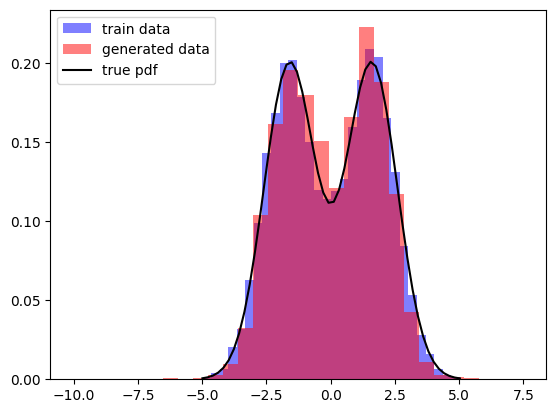

In [3]:
# Case: 1d mixed gaussian

# generate a training dataset
x_train = np.random.randn(N) + (2*(np.random.rand(N) > 0.5) - 1) * 1.6

# train a generative model with score-based model
generative_model_1d_mixed_gaussian = ScoreBasedGenerator(LGBMRegressor(random_state=42)).fit(x_train, noise_strengths=np.sqrt(np.logspace(-3, np.log(x_train.var()), 101)))

# generate samples from the trained model
x_gen = generative_model_1d_mixed_gaussian.sample(n_samples=N, sampling_method=ScoreBasedGenerator.SamplingMethod.EULER).squeeze()

# plot the results
true_pdf = lambda x: 0.5*np.exp(-0.5*(x-1.6)**2)/np.sqrt(2*np.pi) + 0.5*np.exp(-0.5*(x+1.6)**2)/np.sqrt(2*np.pi)
plt.hist(x_train, bins=30, label='train data', color='blue', alpha=0.5, density=True)
plt.hist(x_gen, bins=30, label='generated data', color='red', alpha=0.5, density=True)
plt.plot(np.linspace(x_train.min(), x_train.max()), true_pdf(np.linspace(x_train.min(), x_train.max())), 'k-', label='true pdf')
plt.legend(loc='upper left')
plt.show()

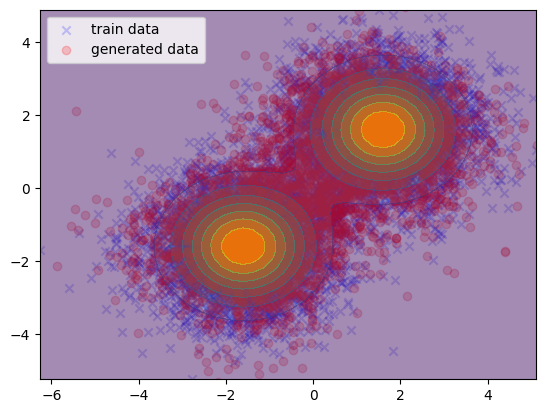

In [4]:
# Case: 2d mixed gaussian

# generate a training dataset
X_train = np.random.randn(N, 2)
label = 2*(np.random.rand(N) > 0.5) - 1
X_train[:, 0] = X_train[:, 0] + label * 1.6
X_train[:, 1] = X_train[:, 1] + label * 1.6

# train a generative model with score-based model
generative_model_2d_mixed_gaussian = ScoreBasedGenerator(
    estimator=CatBoostRegressor(
        verbose=0,
        loss_function='MultiRMSE',
        random_state=42,
    )
)
generative_model_2d_mixed_gaussian.fit(
    X_train,
    noise_strengths=np.sqrt(np.logspace(-3, np.log(max(np.var(X_train, axis=0))), 11)),
)

# generate samples from the trained model
X_gen = generative_model_2d_mixed_gaussian.sample(n_samples=N, sampling_method=ScoreBasedGenerator.SamplingMethod.EULER).squeeze()

# plot the results
true_pdf = lambda X: 0.5*np.exp(-0.5*(X[:, 0]-1.6)**2 - 0.5*(X[:, 1]-1.6)**2)/2/np.pi + 0.5*np.exp(-0.5*(X[:, 0]+1.6)**2 - 0.5*(X[:, 1]+1.6)**2)/2/np.pi
XX_, YY_ = np.meshgrid(np.linspace(X_train[:, 0].min(), X_train[:, 0].max()), np.linspace(X_train[:, 1].min(), X_train[:, 1].max()))
plt.scatter(X_train[:, 0], X_train[:, 1], label='train data', color='blue', alpha=0.2, marker='x')
plt.scatter(X_gen[:, 0], X_gen[:, 1], label='generated data', color='red', alpha=0.2, marker='o')
plt.contourf(XX_, YY_, true_pdf(np.c_[XX_.ravel(), YY_.ravel()]).reshape(XX_.shape), alpha=0.5)
plt.legend(loc='upper left')
plt.xlim(X_train[:, 0].min(), X_train[:, 0].max())
plt.ylim(X_train[:, 1].min(), X_train[:, 1].max())
plt.show()